## Set up and utility functions

In [1]:
import pandas as pd
import numpy as np
import calendar
import pydot
import pickle

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image as pimg
from subprocess import call
from IPython.display import Image as dimg
import matplotlib.pyplot as plt
import graphviz

from sklearn.impute import MissingIndicator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
from sklearn import tree

In [2]:
def read_and_gather(file1, file2, col_sep, value_sep1, value_sep2):
    """Return a concatenated version of two data sets with similar columns.

    Keyword arguments:
    file1, file2 -- file paths to read the two original datasets
    col_sep -- name of column to indicate which dataset a row comes from
    value_sep1, value_sep2 - values to indicate the corresponding dataset a row comes from
    """
    data1 = pd.read_csv(file1)
    data2 = pd.read_csv(file2)
    data1[col_sep] = value_sep1
    data2[col_sep] = value_sep2
    df = pd.concat([data1, data2], axis=0)
    return df

In [3]:
def plot_bar_by_month_city(df, value_col, plot_name, file_name):
    """Plot bar charts by month and city.

    Keyword arguments:
    df - dataset to plot from
    value_col - name of column used for the height of bars
    plot_name - title of plot
    file_name - file name to save plot
    """
    N = 12  # number of categories for the bar chart (i.e. number of months in year)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    p1 = ax.bar(ind, df[df['location'] == 'Boston'][value_col], width)
    p2 = ax.bar(ind + width, df[df['location'] == 'Seattle'][value_col], width)

    ax.set_title(plot_name)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(([calendar.month_abbr[i] for i in range(1, 13)]))
    ax.set_xlabel('month')
    ax.set_ylabel(value_col)

    ax.legend((p1[0], p2[0]), ('Boston', 'Seattle'))
    ax.autoscale_view()
    
    plt.savefig('outputs/{}'.format(file_name))
    plt.show()

In [4]:
def plot_wordcloud(wordcloud_list, mask_img, file_name):
    """Plot word cloud based on text description.
    
    Keyword arguments:
    wordcloud_list - a list of concatenated texts from all observations
    mask_img - a numpy array that represents the mask image outlining the wordcloud
    file_name - file name to save plot
    """
    wordcloud = WordCloud(stopwords=stopwords, 
                          background_color="white", 
                          random_state=42, 
                          mask=mask_img,
                          contour_color='black',
                          contour_width=1).generate(wordcloud_list)
    plt.figure(figsize=(20, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    
    plt.savefig('outputs/{}'.format(file_name))
    plt.show()

In [5]:
listings = read_and_gather('data/boston/listings.csv', 'data/seattle/listings.csv', 
                           'location', 'Boston', 'Seattle')
reviews = read_and_gather('data/boston/reviews.csv', 'data/seattle/reviews.csv', 
                          'location', 'Boston', 'Seattle')
cal = read_and_gather('data/boston/calendar.csv', 'data/seattle/calendar.csv', 
                      'location', 'Boston', 'Seattle')

## Part 1: Demand/ visitors-related

Using number of unique reviewers as a proxy for number of visitors, we want to compare travel demand between cities (Boston vs Seattle) at different points in time. Also, we investigate whether this trend of demand is generally upward overtime.  

### Q1. What are the busiest times of the year to visit each city? Which city among the two seems to be more popular?

In [6]:
reviews['month'] = pd.DatetimeIndex(reviews['date']).month

n_reviewers = (
    reviews
    .groupby(['location', 'month'])
    .nunique()['reviewer_id']
    .rename('count')
    .reset_index()
)

n_reviewers

location  month  count
0    Boston      1   2039
1    Boston      2   1862
2    Boston      3   3691
3    Boston      4   5921
4    Boston      5   7904
5    Boston      6   8136
6    Boston      7   9078
7    Boston      8  10102
8    Boston      9   5846
9    Boston     10   5971
10   Boston     11   3634
11   Boston     12   2178
12  Seattle      1   2758
13  Seattle      2   2529
14  Seattle      3   3993
15  Seattle      4   4045
16  Seattle      5   5609
17  Seattle      6   8188
18  Seattle      7  10100
19  Seattle      8  12511
20  Seattle      9  11213
21  Seattle     10   8534
22  Seattle     11   6367
23  Seattle     12   5439

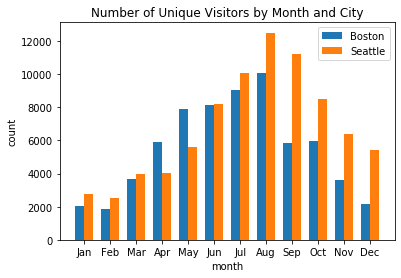

In [7]:
plot_bar_by_month_city(n_reviewers, 
                       'count', 
                       'Number of Unique Visitors by Month and City',
                       'num_visitors_by_month.png')

### Q2. Is there a general upward trend of number of visitors over time?

In [8]:
visitors_over_time = (
    reviews
    .groupby(['location', 'date'])['reviewer_id']
    .nunique()
    .rename('count')
    .reset_index()
    .pivot_table(values='count', index='date', columns='location', aggfunc=np.sum, fill_value=0)
    .reset_index()
)
visitors_over_time

location        date  Boston  Seattle
0         2009-03-21       1        0
1         2009-04-23       1        0
2         2009-05-01       1        0
3         2009-06-07       0        1
4         2009-06-28       0        1
...              ...     ...      ...
2275      2016-09-02      96        0
2276      2016-09-03      70        0
2277      2016-09-04      82        0
2278      2016-09-05     125        0
2279      2016-09-06      66        0

[2280 rows x 3 columns]

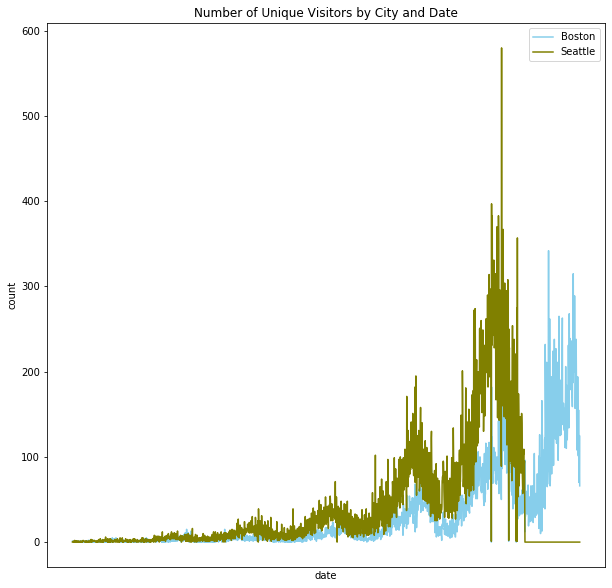

In [9]:
plt.figure(figsize=(10, 10))
plt.plot('date', 'Boston', data=visitors_over_time, color='skyblue')
plt.plot('date', 'Seattle', data=visitors_over_time, color='olive')
plt.legend()
plt.xlabel('date')
plt.ylabel('count')
plt.xticks([])
plt.title('Number of Unique Visitors by City and Date')
plt.savefig('outputs/num_visitors_over_time.png')
plt.show()

## Part 2: Supply/ listings-related

### Q1. What is the general trend of number of listings over time?

In [10]:
bos_lists_over_time = (
    cal
    .query('location == "Boston"')
    .groupby('date')['listing_id']
    .nunique()
)
sea_lists_over_time = (
    cal
    .query('location == "Seattle"')
    .groupby('date')['listing_id']
    .nunique()
)

print('Number of Distinct Listings by Date')
print('##########')
print('For Boston')
print(bos_lists_over_time.value_counts())
print('##########')
print('For Seatle')
print(sea_lists_over_time.value_counts())

Number of Distinct Listings by Date
##########
For Boston
3585    365
Name: listing_id, dtype: int64
##########
For Seatle
3818    365
Name: listing_id, dtype: int64


### Q2. Do the number of booked listings align with the demand/number of visitors at certain period?

In [11]:
cal['month'] = pd.DatetimeIndex(cal['date']).month
tot_avail = (
    cal
    .groupby(['location', 'month', 'available'])
    .nunique()['listing_id']
    .rename('count')
    .reset_index()
)
tot_avail['prop'] = (
    tot_avail
    .groupby(['location', 'month'])
    .transform(lambda x: x / x.sum())
)
not_avail = (
    tot_avail
    .query('available == "f"')
    .drop('available', axis=1)
)
not_avail

location  month  count      prop
0    Boston      1   1677  0.440042
2    Boston      2   1617  0.437263
4    Boston      3   1886  0.478559
6    Boston      4   2111  0.536604
8    Boston      5   1976  0.526652
10   Boston      6   1891  0.514558
12   Boston      7   1849  0.507549
14   Boston      8   1822  0.501514
16   Boston      9   3460  0.567958
18   Boston     10   2829  0.555032
20   Boston     11   2250  0.487752
22   Boston     12   1944  0.445361
24  Seattle      1   3007  0.453544
26  Seattle      2   1933  0.400373
28  Seattle      3   1573  0.347778
30  Seattle      4   1652  0.354963
32  Seattle      5   1525  0.360520
34  Seattle      6   1520  0.358491
36  Seattle      7   1665  0.399472
38  Seattle      8   1523  0.372919
40  Seattle      9   1365  0.340060
42  Seattle     10   1216  0.310997
44  Seattle     11   1141  0.291667
46  Seattle     12   1060  0.269995

In [12]:
print('Average percent of booked listings in Boston: ', 
      not_avail[not_avail['location'] == 'Boston']['prop'].mean())

print('Average percent of booked listings in Seattle: ', 
      not_avail[not_avail['location'] == 'Seattle']['prop'].mean())

Average percent of booked listings in Boston:  0.4999036795755978
Average percent of booked listings in Seattle:  0.3550649298243405


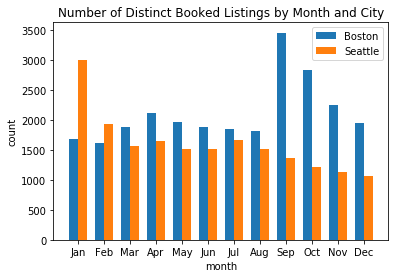

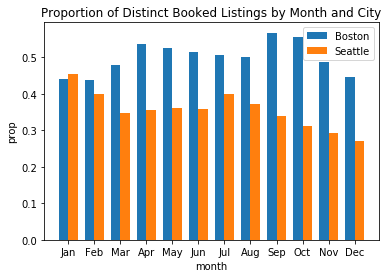

In [13]:
plot_bar_by_month_city(not_avail, 
                       'count', 
                       'Number of Distinct Booked Listings by Month and City',
                       'count_booked_listings.png')
plot_bar_by_month_city(not_avail, 
                       'prop', 
                       'Proportion of Distinct Booked Listings by Month and City',
                       'prop_booked_listings.png')

### Q3. What is the vibe of each city based on listing and neighborhood descriptions?

In [14]:
# concatenate descriptions into text objects to be used for wordclouds
bos_list_desc = ' '.join(desc for desc in listings[listings['location'] == 'Boston']
                         ['description'])
sea_list_desc = ' '.join(desc for desc in listings[listings['location'] == 'Seattle']
                         ['description'])

bos_neigh_desc = ' '.join(desc for desc in listings[listings['location'] == 'Boston']
                          ['neighborhood_overview'] if str(desc) != 'nan')
sea_neigh_desc = ' '.join(desc for desc in listings[listings['location'] == 'Seattle']
                          ['neighborhood_overview'] if str(desc) != 'nan')

# update default set of stopwords with frequently occurring words that are uncharacteristic
stopwords = set(STOPWORDS)
stopwords.update(['Boston', 'Seattle', 'apartment', 'house', 'living', 'room', 'space', 
                  'bed', 'neighborhood', 'home', 'guest'])

# create masks from images that outlines the shapes of our wordclouds
bos_mask = np.array(pimg.open('data/boston_map_outline.jpg'))
sea_mask = np.array(pimg.open('data/seattle_map_outline.jpg'))

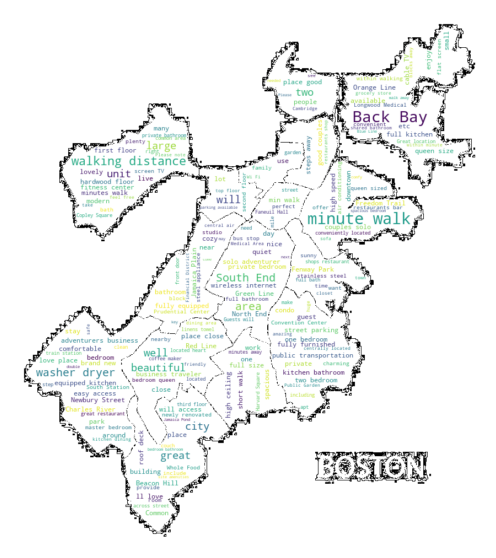

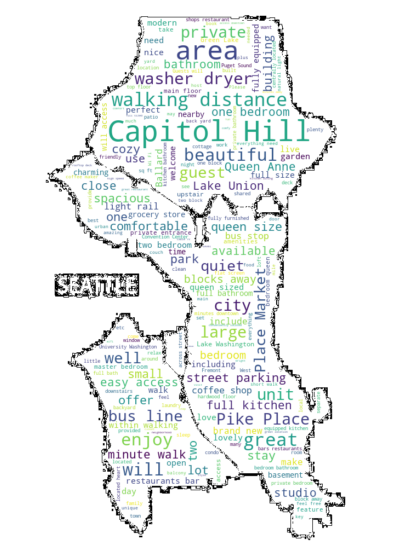

In [15]:
plot_wordcloud(bos_list_desc, bos_mask, 'bos_loc_wordcloud.png')
plot_wordcloud(sea_list_desc, sea_mask, 'sea_loc_wordcloud.png')

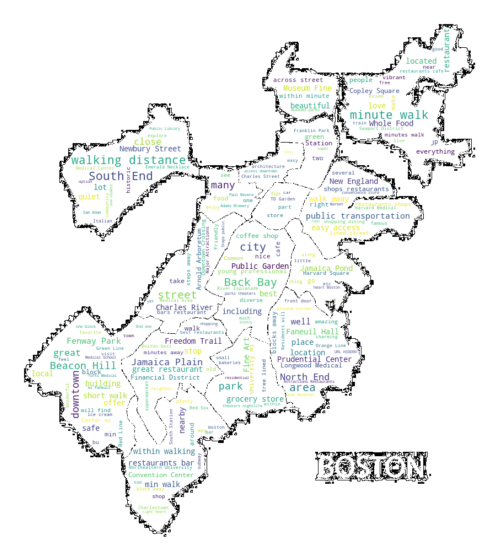

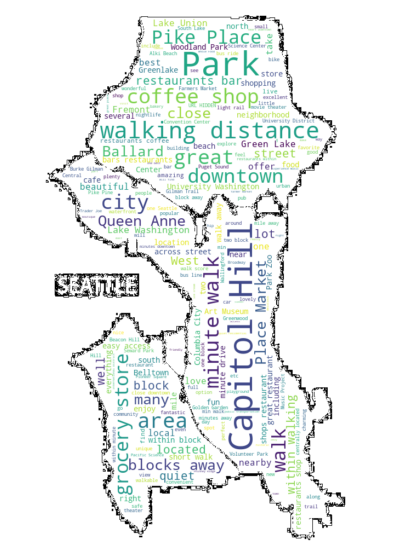

In [16]:
plot_wordcloud(bos_neigh_desc, bos_mask, 'bos_neigh_wordcloud.png')
plot_wordcloud(sea_neigh_desc, sea_mask, 'sea_neigh_wordcloud.png')

## Part 3: Pricing

### Q1. Price comparison between cities and time periods of the year

In [17]:
# clean price column so it will be used as numeric variable
cal['price'] = (
    cal['price']
    .str.replace('$', '')
    .str.replace(',', '')
    .astype(float)
)

mean_prices_loc = (
    cal
    .groupby(['location', 'month'])
    .mean()['price']
    .reset_index()
)
mean_prices_loc

location  month       price
0    Boston      1  182.799671
1    Boston      2  180.961028
2    Boston      3  181.818742
3    Boston      4  197.252890
4    Boston      5  193.712295
5    Boston      6  196.535302
6    Boston      7  202.486309
7    Boston      8  203.330142
8    Boston      9  237.047727
9    Boston     10  233.416248
10   Boston     11  202.924416
11   Boston     12  192.601915
12  Seattle      1  122.912176
13  Seattle      2  124.293927
14  Seattle      3  128.644488
15  Seattle      4  135.097005
16  Seattle      5  139.538183
17  Seattle      6  147.473137
18  Seattle      7  152.094150
19  Seattle      8  150.656594
20  Seattle      9  143.255949
21  Seattle     10  137.031939
22  Seattle     11  135.688738
23  Seattle     12  137.251835

In [18]:
print('Average listing price in Boston: ', 
      mean_prices_loc[mean_prices_loc['location'] == 'Boston']['price'].mean())

print('Average listing price in Seattle: ', 
      mean_prices_loc[mean_prices_loc['location'] == 'Seattle']['price'].mean())

Average listing price in Boston:  200.40722365532724
Average listing price in Seattle:  137.8281767238954


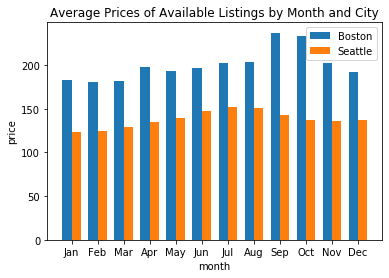

In [19]:
plot_bar_by_month_city(mean_prices_loc, 
                       'price', 
                       'Average Prices of Available Listings by Month and City',
                       'price_over_time.png')

### Q4. What listing properties might contribute to price prediction?

In [20]:
# remove rows with no price since price is our response variable
modeling_cal = (
    cal
    .dropna(subset=['price'], axis=0)
    .filter(items=['listing_id', 'month', 'price'])
)

# remove text columns (categorical variables with more than 20 levels), metadata, and columns with >40% missing
# impute the remaining numeric columns with 0 and create indicator variables
num_cols = [i for i in listings.select_dtypes(include='number').columns 
            if not i.endswith('id') 
            and i not in ['latitude', 'longitude']]
cat_cols = [i for i in listings.select_dtypes(include='object').columns 
            if 1 < listings[i].nunique() <= 20 
            and i not in ['last_scraped', 'state', 'market', 'calendar_last_scraped']]
listings_smaller = listings[['id'] + num_cols + cat_cols]
missing_perc = listings_smaller.isnull().mean()
na_cols_dropped = listings_smaller.columns[missing_perc > 0.4]
na_cols_imputed = listings_smaller.columns[(0 < missing_perc) & (missing_perc <= 0.4)]
listings_missing_ind = (
    listings_smaller[na_cols_imputed]
    .isnull()
    .astype(int)
    .add_suffix('_missing')
)
listings_dropped = listings_smaller.drop(na_cols_dropped, axis=1)
listings_dropped[na_cols_imputed] = listings_dropped[na_cols_imputed].fillna(0)
modeling_listings = pd.concat([listings_dropped, listings_missing_ind], axis=1)

# join calendar with listings dataset to utilize ratings and review scores
modeling_data = (
    pd
    .merge(modeling_cal, modeling_listings, how='inner', left_on='listing_id', right_on='id')
    .drop(['listing_id', 'id'], axis=1)
    .drop_duplicates()
)

# create dummy variables for categorical columns
modeling_dummies = pd.get_dummies(modeling_data)

In [21]:
X = modeling_dummies.loc[:, modeling_dummies.columns != 'price']
y = modeling_dummies['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [22]:
# # build a baseline random forest using mostly default parameters
# rf = RandomForestRegressor(n_estimators = 500, random_state = 42)
# rf.fit(X_train, y_train)

# # save model in a pickle file to save time whenever rerunning notebook
# pickle.dump(rf, open('models/baseline_rf.sav', 'wb'))

In [23]:
rf = pickle.load(open('models/baseline_rf.sav', 'rb'))
y_preds = rf.predict(X_test)
test_r2 = r2_score(y_test, y_preds)

print('Test R-squared score: ', test_r2)  # 0.859

Test R-squared score:  0.8590762084269248


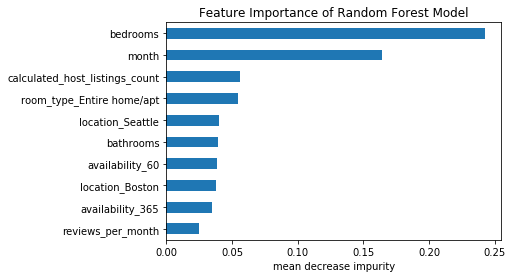

In [24]:
# plot the 10 most important features according to this model
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).sort_values(ascending=True).plot(kind='barh')
plt.title('Feature Importance of Random Forest Model')
plt.xlabel('mean decrease impurity')
plt.savefig('outputs/rf_feat_imp.png')
plt.show()

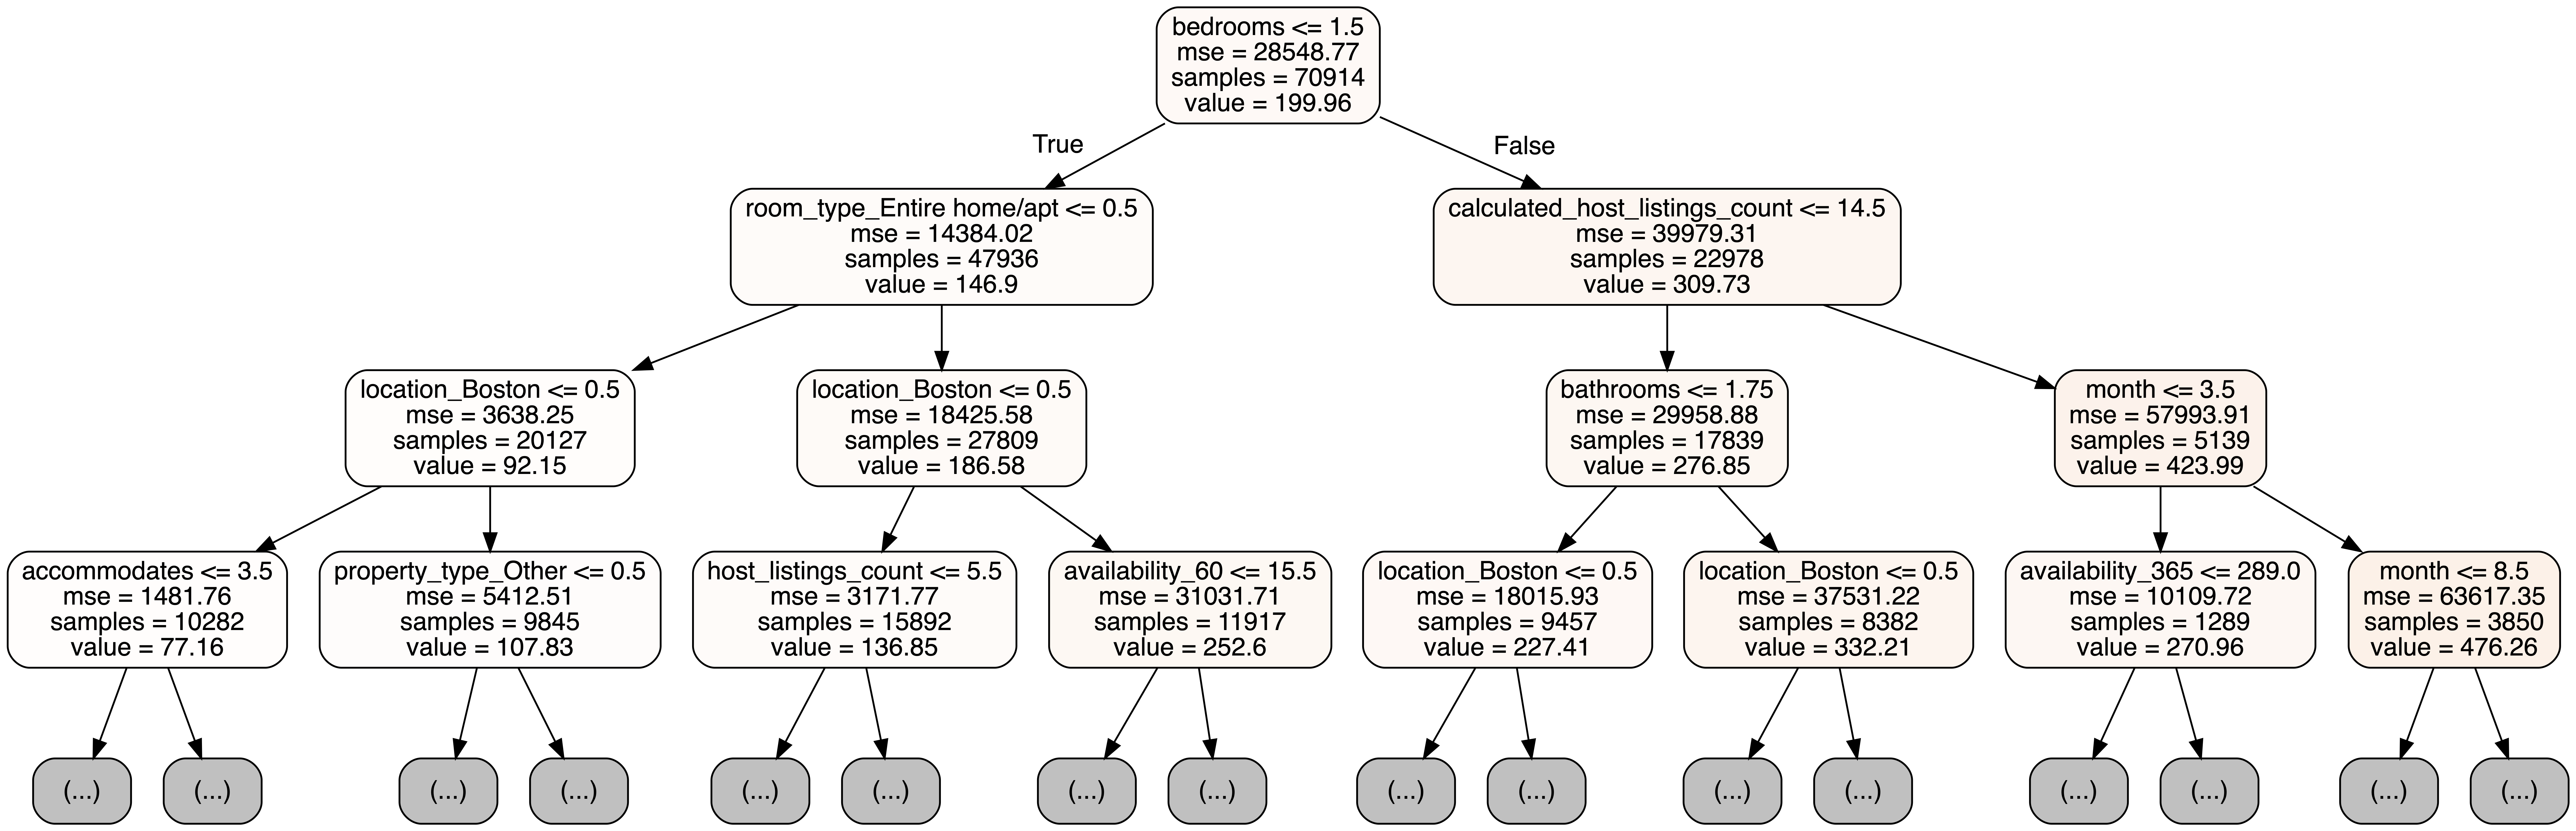

In [25]:
# export visualization of a single tree of the model as dot file
# only draw out the first 3 levels due to speed
export_graphviz(rf.estimators_[5], out_file='outputs/tree.dot', 
                feature_names = X_train.columns,
                max_depth=3, leaves_parallel=True,
                class_names = 'price',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# display in jupyter notebook
dimg(filename = 'outputs/tree.png')